# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [70]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [71]:
from sagemaker.session import Session
from sagemaker import get_execution_role
import os
role = get_execution_role()
session = sagemaker.Session()
region = session.boto_region_name
bucket = session.default_bucket()
s3_prefix = "project_image_classification"

In [3]:
# from botocore.exceptions import ClientError
# def upload_file_to_s3(file_name, s3_prefix):
#     object_name = os.path.join(s3_prefix, file_name)
#     s3_client = boto3.client('s3')
#     try:
#         response = s3_client.upload_file(file_name, bucket, object_name)
#     except ClientError as e:
#         logging.error(e)
#         return False
    
# s3_prefix = "project_image_classification"

# train_path = './dogImages/train/'
# validation_path = './dogImages/valid/'
# test_path = './dogImages/test/'

# upload_file_to_s3(train_path, s3_prefix)
# print("Train file uploaded!")
# upload_file_to_s3(validation_path, s3_prefix)
# print("Validation file uploaded!")
# upload_file_to_s3(test_path, s3_prefix)
# print("Test file uploaded!")

In [14]:
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages/train s3://${DEFAULT_S3_BUCKET}/project_image_classification/train/
!aws s3 sync ./dogImages/valid s3://${DEFAULT_S3_BUCKET}/project_image_classification/valid/
!aws s3 sync ./dogImages/test s3://${DEFAULT_S3_BUCKET}/project_image_classification/test/

upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://sagemaker-us-east-1-664720356610/project_image_classification/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg to s3://sagemaker-us-east-1-664720356610/project_image_classification/test/001.Affenpinscher/Affenpinscher_00078.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://sagemaker-us-east-1-664720356610/project_image_classification/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://sagemaker-us-east-1-664720356610/project_image_classification/test/001.Affenpinscher/Affenpinscher_00023.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg to s3://sagemaker-us-east-1-664720356610/project_image_classification/test/001.Affenpinscher/Affenpinscher_00048.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00139.jpg to s3://sagemaker-us-east-1

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [72]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)


In [4]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
#     "batch-size": CategoricalParameter([128, 64]),
    "epochs": CategoricalParameter([5,10,20,40,100,200])
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [5]:
#TODO: Create estimators for your HPs

from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

https://aws.amazon.com/blogs/machine-learning/detecting-hidden-but-non-trivial-problems-in-transfer-learning-models-using-amazon-sagemaker-debugger/

When Amazon SageMaker spins up the training instance, it automatically downloads the training and validation data from Amazon Simple Storage Service (Amazon S3) into a local folder on the training instance. We can retrieve the local path with os.environ['SM_CHANNEL_TRAIN'] and os.environ['SM_CHANNEL_TEST']

In [73]:

# refer to https://sagemaker.readthedocs.io/en/stable/overview.html#prepare-a-training-script
train_path= "s3://{}/{}/{}/".format(bucket, s3_prefix, 'train')
valid_path= "s3://{}/{}/{}/".format(bucket, s3_prefix, 'valid')
test_path= "s3://{}/{}/{}/".format(bucket, s3_prefix, 'test')

s3_output_dir = "s3://{}/{}/".format(bucket, s3_prefix)
s3_model_dir = "s3://{}/{}/".format(bucket, "project_image_classification/model")

os.environ['SM_CHANNEL_TRAIN']=train_path
os.environ['SM_CHANNEL_VAL']=valid_path
os.environ['SM_CHANNEL_TEST']=test_path
os.environ['SM_MODEL_DIR']=s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']=s3_output_dir



In [74]:
train_path, valid_path, test_path

('s3://sagemaker-us-east-1-664720356610/project_image_classification/train/',
 's3://sagemaker-us-east-1-664720356610/project_image_classification/valid/',
 's3://sagemaker-us-east-1-664720356610/project_image_classification/test/')

In [75]:
os.environ['SM_MODEL_DIR']

's3://sagemaker-us-east-1-664720356610/project_image_classification/model/'

In [9]:
# TODO: Fit your HP 

tuner.fit({"train": train_path,
           "val": valid_path,  # the key has to be "val"
           "test": test_path}) # TODO: Remember to include your data channels

..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [10]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator(best_training_job=None) #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()



2022-03-01 05:18:35 Starting - Preparing the instances for training
2022-03-01 05:18:35 Downloading - Downloading input data
2022-03-01 05:18:35 Training - Training image download completed. Training in progress.
2022-03-01 05:18:35 Uploading - Uploading generated training model
2022-03-01 05:18:35 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'epochs': '"200"',
 'lr': '0.0011390279487180027',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-03-01-04-59-34-534"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-664720356610/pytorch-training-2022-03-01-04-59-34-534/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [7]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    CollectionConfig,
    rule_configs,
    ProfilerRule
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

# collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
#     "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "100","eval.save_interval": "10"})]

hook_config = DebuggerHookConfig(
#     collection_configs=collection_configs,
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

from sagemaker.debugger import ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [8]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters = {"learning_rate": 0.0011390279487180027, 
                      'batch-size': 32,
                      'epochs': 2}, # choose a small epoch due to budget
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config
)

estimator.fit({"train": train_path,
               "val": valid_path,  # the key has to be "val"
               "test": test_path})

2022-03-02 21:07:10 Starting - Starting the training job...
2022-03-02 21:07:15 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-03-02 21:09:06 Starting - Preparing the instances for training......
2022-03-02 21:10:06 Downloading - Downloading input data............
2022-03-02 21:12:07 Training - Downloading the training image.........
2022-03-02 21:13:37 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-03-02 21:13:32,624 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-03-02 21:13:32,645 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-03-02 21:13:34,068 sag

In [9]:
# TODO: Plot a debugging output.

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals



In [19]:
steps_train, vals_train = get_data(trial, tname = 'CrossEntropyLoss_output_0', mode=ModeKeys.TRAIN)
print("loaded TRAIN data")

loaded TRAIN data


In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

In [12]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()

[2022-03-02 21:26:11.164 ip-172-16-172-221:29431 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-664720356610/pytorch-training-2022-03-02-21-07-09-824/debug-output
[2022-03-02 21:26:11.391 ip-172-16-172-221:29431 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-03-02 21:26:12.418 ip-172-16-172-221:29431 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [21]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

1

In [22]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

0

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


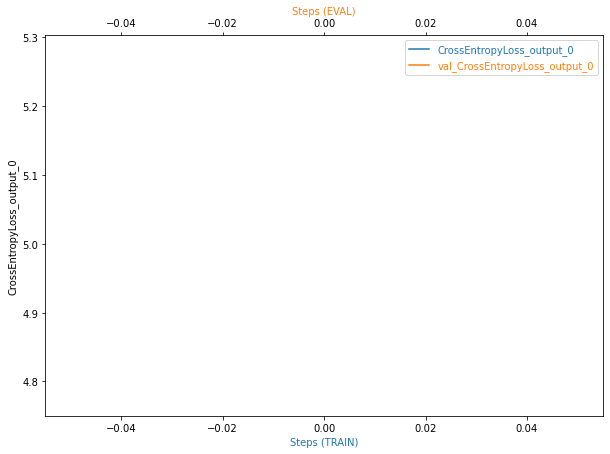

In [15]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [24]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

You will find the profiler report in s3://sagemaker-us-east-1-664720356610/pytorch-training-2022-03-02-17-12-49-473/rule-output
2022-03-02 17:30:02     430972 pytorch-training-2022-03-02-17-12-49-473/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-03-02 17:30:01     289111 pytorch-training-2022-03-02-17-12-49-473/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-03-02 17:29:56        548 pytorch-training-2022-03-02-17-12-49-473/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-03-02 17:29:56      55971 pytorch-training-2022-03-02-17-12-49-473/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-03-02 17:29:56       2166 pytorch-training-2022-03-02-17-12-49-473/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-03-02 17:29:56        130 pytorch-training-2022-03-02-17-12-49-473/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.jso

## Model Deploying

In [25]:
# TODO: Deploy your model to an endpoint

# in case the model has already been saved, run the following
# https://sagemaker-examples.readthedocs.io/en/latest/frameworks/pytorch/get_started_mnist_deploy.html
# model = PyTorchModel(
#     entry_point="inference.py",
#     source_dir="code",
#     role=role,
#     model_data=pt_mnist_model_data,
#     framework_version="1.5.0",
#     py_version="py3",
# )

predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium") # TODO: Add your deployment configuration like instance type and number of instances

---------------!

In [83]:
# Load the model using inference.py
from sagemaker.pytorch.model import PyTorchModel
model_location = 's3://sagemaker-us-east-1-664720356610/pytorch-training-2022-03-02-21-07-09-824/output/model.tar.gz'
    
estimator = PyTorchModel(model_data=model_location,
                             role=role,
                             entry_point='inference.py',
                             py_version='py3',
                             framework_version='1.5')

predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

-----------!

In [84]:
predictor

Text(0.5, 1.0, 'Cocker_spaniel_03743.jpg')

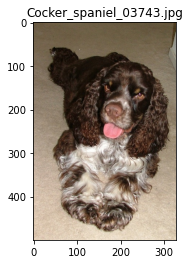

In [125]:
# TODO: Run an prediction on the endpoint
import random
import os
import numpy as np
path = 'dogImages/test/'
folders=os.listdir(path)
folder=random.choice(folders)
file = random.choice(os.listdir(path + folder))

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Read Images
img = mpimg.imread(path + folder + '/' + file)
 
# Output Images
plt.imshow(img)
plt.title(file)

In [126]:
# resize images for prediction

print('original image size', img.shape)
img = np.resize(img, (3,224,224))
from numpy import asarray
data = asarray(img)
print(type(data))
# summarize shape
print('After resizing the image has size: ', data.shape)

original image size (500, 327, 3)
<class 'numpy.ndarray'>
After resizing the image has size:  (3, 224, 224)


In [127]:
data = data.astype(np.float32)
data = np.expand_dims(data, axis=0)
data.shape

(1, 3, 224, 224)

In [128]:
response = predictor.predict(data)   # TODO: Query the endpoint
print(response)

[[-568.42437744 -632.29309082 -391.87716675 -303.94378662 -285.21353149
  -726.77685547 -351.24142456 -335.19973755 -442.13619995 -353.49957275
  -435.99966431 -445.23196411 -452.10571289 -423.18386841 -558.51470947
  -237.05378723 -509.37011719 -503.18768311 -682.69598389 -450.87200928
  -476.73925781 -472.77114868 -430.14553833 -652.69073486 -630.2053833
  -464.69186401 -615.362854   -652.81170654 -692.83862305 -406.87228394
  -640.06170654 -313.08996582 -692.36724854 -452.34957886 -426.72937012
  -589.13458252 -423.24771118 -340.74276733 -425.27618408 -466.32699585
  -323.81564331 -461.18447876 -399.26708984 -502.38262939 -320.29910278
  -386.81710815 -110.33052063 -331.27709961 -583.27429199 -414.64776611
  -614.34448242 -536.16412354 -370.79837036 -689.05865479 -525.44799805
  -525.37005615 -475.35592651 -650.75805664 -653.1897583  -335.04629517
  -472.44622803 -529.88897705 -520.44433594 -518.41503906 -283.51635742
  -350.1484375  -452.41983032 -446.93826294 -391.23602295 -366.94

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()